# Handwritten Digit Recognizer

**Note**: This notebook is desinged to run on CPU (no GPU) runtime.

**[HDR-01]**

Install Flax and Optax

In [14]:
%%bash
pip install -q flax optax
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.0
jax                           0.3.17
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[HDR-02]**

Import modules.

In [15]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state, checkpoints

plt.rcParams.update({'font.size': 12})

**[HDR-03]**

Define a CNN model with dual convolutional filter layers.

In [18]:
class DoubleLayerCNN(nn.Module):
    @nn.compact
    def __call__(self, x, get_pooling_output1=False, get_pooling_output2=False):
        x = x.reshape([-1, 28, 28, 1])

        x = nn.Conv(features=32, kernel_size=(5, 5), use_bias=True)(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        if get_pooling_output1:
            return x

        x = nn.Conv(features=64, kernel_size=(5, 5), use_bias=True)(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        if get_pooling_output2:
            return x

        x = x.reshape([x.shape[0], -1]) # Flatten
        x = nn.Dense(features=1024)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.softmax(x)
        return x

**[HDR-04]**

Create a TrainState object to restore the checkpoint.

In [19]:
class TrainState(train_state.TrainState):
    epoch: int
    dropout_rng: type(random.PRNGKey(0))


variables = DoubleLayerCNN().init(random.PRNGKey(0), jnp.zeros([1, 28*28]))

state = TrainState.create(
    apply_fn=DoubleLayerCNN().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.001),
    dropout_rng=random.PRNGKey(0),
    epoch=0)

jax.tree_util.tree_map(lambda x: x.shape, state.params)

FrozenDict({
    Conv_0: {
        bias: (32,),
        kernel: (5, 5, 1, 32),
    },
    Conv_1: {
        bias: (64,),
        kernel: (5, 5, 32, 64),
    },
    Dense_0: {
        bias: (1024,),
        kernel: (3136, 1024),
    },
    Dense_1: {
        bias: (10,),
        kernel: (1024, 10),
    },
})

**[HDR-05]**

Mount Google Drive content.

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**[HDR-06]**

Confirm that the checkpoint file is in the folder.

In [21]:
!ls -lh '/content/gdrive/My Drive/checkpoints/'

total 75M
-rw------- 1 root root 38M Oct  2 23:24 DoubleLayerCNN_checkpoint_16
-rw------- 1 root root 37M Oct  2 09:43 SingleLayerCNN_checkpoint_16


**[HDR-07]**

Restore the latest checkpoint.

In [22]:
state = checkpoints.restore_checkpoint(
    ckpt_dir='/content/gdrive/My Drive/checkpoints/',
    prefix='DoubleLayerCNN_checkpoint_',
    target=state)

**[HDR-08]**

Define a Javascript function to show a drawing canvas.

In [23]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e) {
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0, 0, 0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY*0.2);
            y = Math.floor(e.offsetX*0.2) + 1;
            for (var dy = 0; dy < 2; dy++) {
                for (var dx = 0; dx < 2; dx++) {
                    if ((x + dx < 28) && (y + dy < 28)) {
                        pixels[(y+dy)+(x+dx)*28] = 1;
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });
    
    function set_value() {
        var result = "";
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ",";
        google.colab.kernel.invokeFunction(
                          'notebook.set_image', [result], {});
    }
    
    function clear_value() {
        canvas.getContext("2d").fillStyle = "rgb(255, 255, 255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    }
</script>
"""

**[HDR-09]**

Show a drawing canvas.

In [24]:
from google.colab import output  
from IPython.display import HTML

def set_image(result):
    global image
    image = np.array([float(x) for x in result.split(',')[:-1]])

image = None
output.register_callback('notebook.set_image', set_image)

HTML(input_form + javascript)

**[HDR-10]**

Make a prediction for the handwritten digit on the drawing canvas.

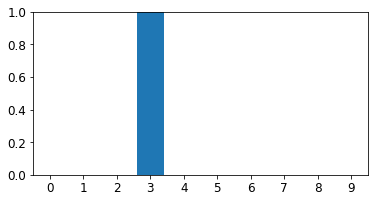

In [31]:
input_data = jnp.asarray([image.reshape([1, 28*28])])
predictions = jax.device_get(
    state.apply_fn({'params': state.params}, input_data))
predictions = predictions[0]

fig = plt.figure(figsize=(6, 3))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xticks(range(10))
subplot.set_xlim([-0.5, 9.5])
subplot.set_ylim([0, 1])
_ = subplot.bar(range(10), predictions, align='center')

**[HDR-11]**

Get images after the pooling layers.

In [32]:
pooling_output_1 = jax.device_get(
    state.apply_fn({'params': state.params}, input_data,
                   get_pooling_output1=True))

pooling_output_2 = jax.device_get(
    state.apply_fn({'params': state.params}, input_data,
                   get_pooling_output2=True))

**[HDR-12]**

Show images from the first pooling layer.

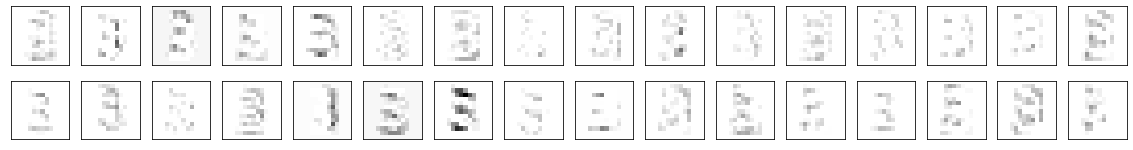

In [33]:
layer = pooling_output_1[0]
v_max = np.max(layer)
fig = plt.figure(figsize=(20, 2.5))
for i in range(layer.shape[-1]):
    subplot = fig.add_subplot(2, 16, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(layer[:, :, i], vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

**[HDR-13]**

Show images from the second pooling layer.

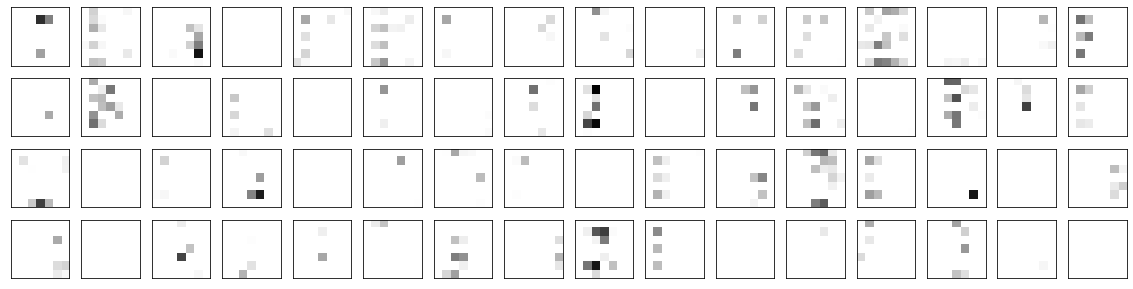

In [34]:
layer = pooling_output_2[0]
v_max = np.max(layer)
fig = plt.figure(figsize=(20, 5))
for i in range(layer.shape[-1]):
    subplot = fig.add_subplot(4, 16, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(layer[:, :, i], vmin=0, vmax=v_max, cmap=plt.cm.gray_r)